# KAGGLE COMPETITION
### House Prices: Advanced Regression Techniques
Predict sales prices and practice feature engineering, RFs, and gradient boosting

#### Por Guilherme Nicchio

### LIBRARIES

In [8]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import norm, skew
from scipy.special import boxcox1p

from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
#Recursive Feature Elimination
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder


import xgboost as xgb

### LOADING DATA SETS

In [9]:
df_train = pd.read_csv("train.csv", header = 0, delimiter = ",")
df_test = pd.read_csv("test.csv", header = 0, delimiter = ",")
sub_df = pd.read_csv("sample_submission.csv", header = 0, delimiter = ",")

In [54]:
df_train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalArea
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,2566
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,2524
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,2706
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,2473
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,3343
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000,2158
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,8,2007,WD,Normal,307000,3380
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,Shed,350,11,2009,WD,Normal,200000,3197
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900,2726
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,1,2008,WD,Normal,118000,2068


Joining df_test with sample submissions

In [10]:
df_test = sub_df.merge(df_test)

In [11]:
print("Train set shape:", df_train.shape)
print("Test set shape:", df_test.shape)

Train set shape: (1460, 81)
Test set shape: (1459, 81)


# FEATURE ENGINEERING

### SUMMING AREAS TO CREATE A BETTER FEATURE

TotalBsmtSF, 1stFlrSF, 2ndFlrSF

In [12]:
df_train['TotalArea'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']
df_test['TotalArea'] = df_test['TotalBsmtSF'] + df_test['1stFlrSF'] + df_test['2ndFlrSF']

Deleting the old columns

In [13]:
for i in ['TotalBsmtSF', '1stFlrSF', "2ndFlrSF"]:
    df_train = df_train.drop(i, axis = 1)
    df_test = df_test.drop(i, axis = 1)

In [14]:
print("Train set shape:", df_train.shape)
print("Test set shape:", df_test.shape)

Train set shape: (1460, 79)
Test set shape: (1459, 79)


### OUTLIERS IN TRAIN SET

Looking at the features in the data set it is expected that **OverallQual** (Overall quality), **Neighborhood**, **GrLivArea** (Above grade (ground) living area square feet), and **Total Area** have a strong relatinship with the Sale Price, so outliers in this variables may make our prediction model bad. So let's take a look at those variables.

**GrLivArea**

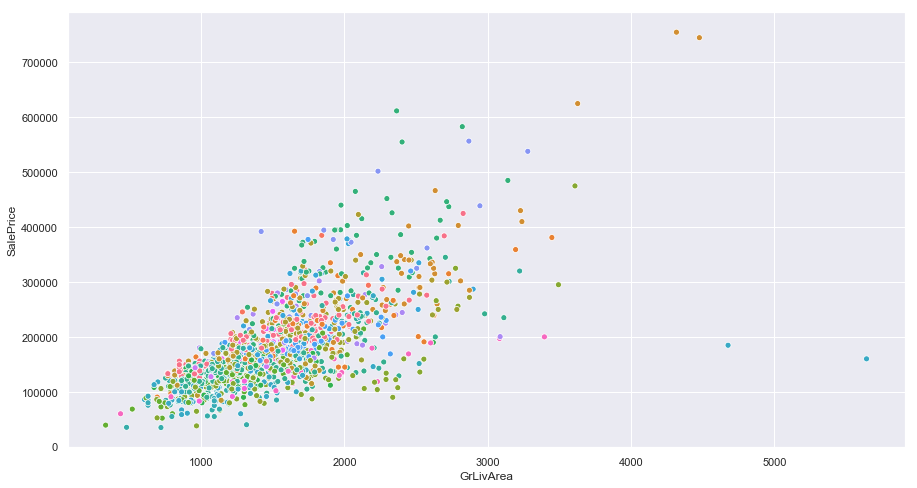

In [15]:
plt.figure(figsize=(15,8))
sns.scatterplot(x = df_train['GrLivArea'], y = df_train['SalePrice'], hue = df_train['Neighborhood'], legend = False)

We notice two points out of the "line" which are very od and we want to remove it.

In [16]:
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4500) & (df_train['SalePrice']<200000)].index)

**TotalArea**

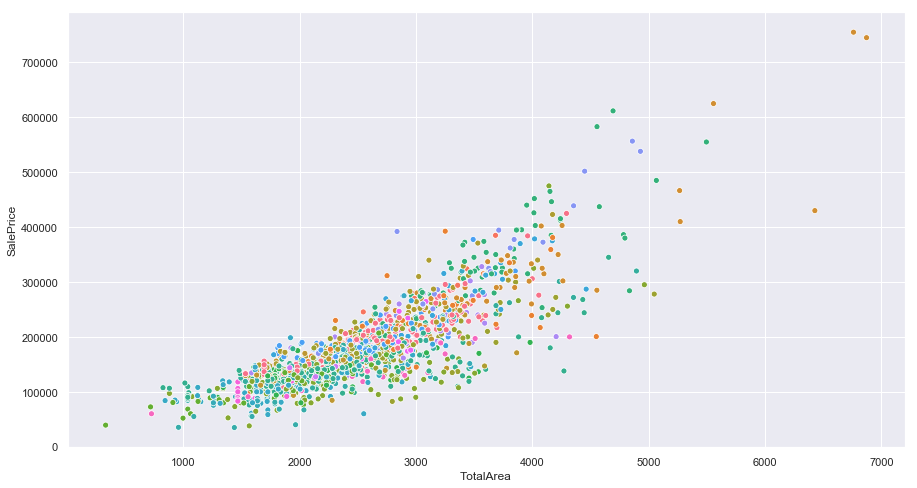

In [17]:
plt.figure(figsize=(15,8))
sns.scatterplot(x = df_train['TotalArea'], y = df_train['SalePrice'], hue = df_train['Neighborhood'], legend = False)

TotalArea seems fine and looks like a linea-ish relation.

**OverallQual**

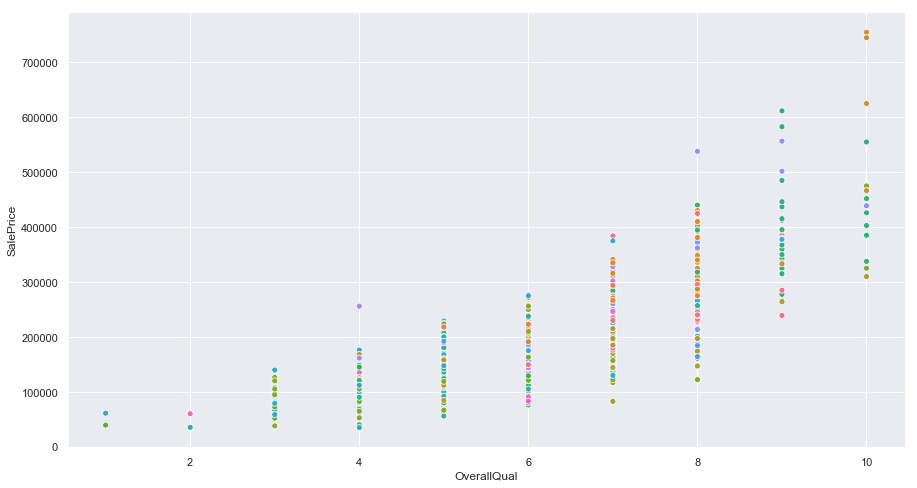

In [18]:
plt.figure(figsize=(15,8))
sns.scatterplot(x = df_train['OverallQual'], y = df_train['SalePrice'], hue = df_train['Neighborhood'], legend = False)

OverallQual seems fine.

How is our train set now?

In [19]:
len_train = df_train.shape[0]
len_train

1458

**Joining both datasets**

In [20]:
df_concat = pd.concat([df_train, df_test], sort = False)

In [21]:
df_concat.shape

(2917, 79)

In [22]:
df_concat = df_concat.drop("Id", axis = 1)

### LOG TRANSFORM TARGET VARIABLE

The target sale price is very skewed so to normalize it we log the target and it become more robust to the model.

Skew: 2.55


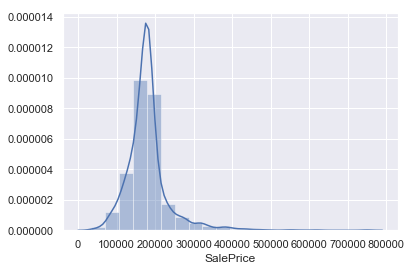

In [23]:
sns.distplot(df_concat['SalePrice'], bins = 20)
print("Skew:", round(df_concat['SalePrice'].skew(),2))

In [24]:
df_concat["SalePrice"] = np.log1p(df_concat["SalePrice"])

Skew: -0.15


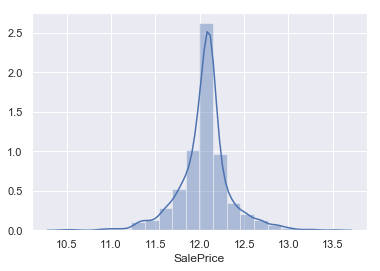

In [25]:
sns.distplot(df_concat['SalePrice'], bins = 20)
print("Skew:", round(df_concat['SalePrice'].skew(),2))

### MISSING VALUES

**Separating continues from categorical features**

In [26]:
continuous = []
categorical = []

for i in df_concat.columns:
    if df_concat[i].dtype == "object":
        categorical.append(i)
    else: continuous.append(i)

print("Continuous:", continuous)
print("-")
print("Categorical:", categorical)

Continuous: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'TotalArea']
-
Categorical: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQua

#### Categorical

In [27]:
isna_sum = df_concat[categorical].isna().sum()
NaN_columns = [i for i in isna_sum.index if df_concat[i].isna().sum() !=0]
df_NaN_values = df_concat[NaN_columns]
missing_categorical = pd.DataFrame(df_NaN_values.isna().sum(), columns = ["Missing values"])
missing_categorical.sort_values(["Missing values"], axis = 0, ascending = False)

,Missing values
PoolQC,2908
MiscFeature,2812
Alley,2719
Fence,2346
FireplaceQu,1420
GarageQual,159
GarageFinish,159
GarageCond,159
GarageType,157
BsmtCond,82


Functional: Home functionality (Assume typical unless deductions are warranted)

- Typ	Typical Functionality
- Min1	Minor Deductions 1
- Min2	Minor Deductions 2
- Mod	Moderate Deductions
- Maj1	Major Deductions 1
- Maj2	Major Deductions 2
- Sev	Severely Damaged
- Sal	Salvage only

In [28]:
df_concat["Functional"].fillna("Typ", inplace = True)

Reading the descriptions of the following features, it is noticeble that an NA means not present so let`s fill the missing with "NA"

In [29]:
for i in ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
            'BsmtFinType2', "MasVnrType", "MSSubClass", "FireplaceQu"]:
    
    df_concat[i].fillna("NA", inplace = True)

In [30]:
isna_sum = df_concat[categorical].isna().sum()
NaN_columns = [i for i in isna_sum.index if df_concat[i].isna().sum() !=0]
df_NaN_values = df_concat[NaN_columns]
df_NaN_values.isna().sum()

MSZoning       4
Utilities      2
Exterior1st    1
Exterior2nd    1
Electrical     1
KitchenQual    1
SaleType       1
dtype: int64

Now that we filled most of the missing values let's fill the rest with the most common value of the feature, the mode.

In [31]:
for i in ["MSZoning", "Utilities", "Exterior1st", "Exterior2nd", "Electrical", "KitchenQual", "SaleType"]:
    df_concat[i].fillna(df_concat[i].mode()[0], inplace = True)

#### Continuous

In [32]:
isna_sum = df_concat[continuous].isna().sum()
NaN_columns = [i for i in isna_sum.index if df_concat[i].isna().sum() !=0]
df_NaN_values = df_concat[NaN_columns]
missing_continuous = pd.DataFrame(df_NaN_values.isna().sum(), columns = ["Missing values"])
missing_continuous.sort_values(["Missing values"], axis = 0, ascending = False)

,Missing values
LotFrontage,486
GarageYrBlt,159
MasVnrArea,23
BsmtFullBath,2
BsmtHalfBath,2
BsmtFinSF1,1
BsmtFinSF2,1
BsmtUnfSF,1
GarageCars,1
GarageArea,1


The **LotFrontage** is the most critical value to be missing, because it means **"Linear feet of street connected to property"**. Therefore its value is possible very correlated with the price. It makes sense that most of the houses in a Neighborhood have a somewhat similar value for this feature. Hence, to solve this issue we group by neighborhood and fill in missing values by the median of all the neighborhood.

In [33]:
df_concat["LotFrontage"] = df_concat.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

For the same reason of the related features in categorical data, it is noticeble that a missing value means not present so let`s fill the missing with 0.

In [34]:
for i in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 
            'BsmtHalfBath', "MasVnrArea", "TotalArea"):
    
    df_concat[i].fillna(0, inplace = True)

**Is there still any missing value?**

In [35]:
sum(df_concat.isna().sum())

0

### SKEWED CONTINUOUS FEATURES

In [36]:
big_skew = [feature for feature in continuous if abs(df_concat[feature].skew()) > 0.75]

In [37]:
print("High skewed data:", big_skew)
len(big_skew)

High skewed data: ['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr', 'GarageYrBlt', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'TotalArea']


20

**APPLYING BOX COX TRANSFORMATION TO SKEWED DATA**

A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape. Normality is an important assumption for many statistical techniques; if your data isn’t normal, applying a Box-Cox means that you are able to run a broader number of tests.

The parameter lambda (0.15) minimizes the standard deviation of a standardized transformed variable. 

In [38]:
for feature in big_skew:
    df_concat[feature] = boxcox1p(df_concat[feature], 0.40)

### GETTING DUMMIES FOR CATEGORICAL VALUES

In [39]:
df_concat = pd.get_dummies(df_concat)
print(df_concat.shape)

(2917, 301)


In [40]:
df_concat.shape

(2917, 301)

## CORRELATION MATRIX

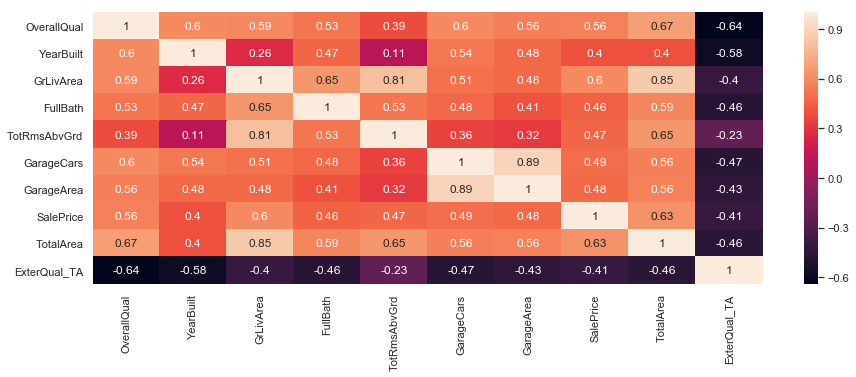

In [41]:
corrmat = df_concat.corr()
high_corr_columns_final = corrmat.index[abs(corrmat["SalePrice"])>0.4]

plt.figure(figsize=(15,5))
g = sns.heatmap(df_concat[high_corr_columns_final].corr(),annot=True)

### SPLITTING THE DATA

In [42]:
len_train

1458

In [45]:
train_set_final = df_concat.iloc[:len_train,:]
test_set_final = df_concat.iloc[len_train:,:]

In [46]:
print(train_set_final.shape)
print(test_set_final.shape)

(1458, 301)
(1459, 301)


# BUILDING THE PREDICTION MODEL

Splitting the train data frame into train and test subsets

In [47]:
X = train_set_final.drop('SalePrice',axis=1)
y = train_set_final[['SalePrice']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

Data for prediction and submit

In [48]:
X_submission = test_set_final.drop('SalePrice',axis=1)

Models to test the score

In [41]:
import lightgbm as lgb

In [42]:
modelsFinal = []
modelsFinal.append(('ENet', make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))))
modelsFinal.append(('Lasso', make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))))
modelsFinal.append(('RF',RandomForestRegressor()))
modelsFinal.append(('GB',GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)))
modelsFinal.append(("KRR",KernelRidge()))
modelsFinal.append(("Xgb",xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)))
modelsFinal.append(("LGB", lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)))

In [43]:
def compute_models(X, y):
    names = []
    scores = []
    frame = pd.DataFrame()
    
    for name, model in modelsFinal:
        model.fit(X, y)
        prediction = model.predict(X_submission)
        frame[name] = prediction
        scores.append(model.score(X_test,y_test))
        names.append(name)
    
    bla = pd.DataFrame(scores, index = names, columns = ["score"])
    print(bla)
    
    return frame

In [1075]:
frame = compute_models(X_train, y_train)

          score
ENet   0.915653
Lasso  0.915687
RF     0.868449
GB     0.904207
KRR    0.910132
Xgb    0.911107
LGB    0.910242


In [1077]:
frame.head()

,ENet,Lasso,RF,GB,KRR,Xgb,LGB
0,11.675174,11.676502,11.691485,11.731262,11.702439,11.732427,11.717868
1,11.927724,11.928032,12.004032,11.995827,12.052659,11.992205,11.953049
2,12.124922,12.124805,12.186338,12.166806,12.147903,12.161936,12.186457
3,12.202135,12.203264,12.156871,12.221538,12.206942,12.176467,12.218126
4,12.141402,12.139968,12.211262,12.137113,12.152978,12.140879,12.141996


It is possible to note that the models build over ENet and Lasso and Xgb have a higher score. So lets create a column with the mean value of the 3 predictions. Mixing models is known to increase accuracy.

In [1122]:
frame["mean"] = (frame["ENet"] + frame["Lasso"] + frame["Xgb"] + frame["LGB"] + frame["GB"]+ frame["KRR"])/6

In [1123]:
frame.head(10)

,ENet,Lasso,RF,GB,KRR,Xgb,LGB,mean
0,11.675174,11.676502,11.691485,11.731262,11.702439,11.732427,11.717868,11.705945
1,11.927724,11.928032,12.004032,11.995827,12.052659,11.992205,11.953049,11.974916
2,12.124922,12.124805,12.186338,12.166806,12.147903,12.161936,12.186457,12.152138
3,12.202135,12.203264,12.156871,12.221538,12.206942,12.176467,12.218126,12.204745
4,12.141402,12.139968,12.211262,12.137113,12.152978,12.140879,12.141996,12.142389
5,12.047464,12.047365,12.115914,12.042377,12.059403,12.073637,12.035569,12.050969
6,12.065346,12.068854,12.084755,12.084885,12.030502,12.085721,12.059416,12.065787
7,11.990355,11.990263,12.091752,12.009845,12.005180,11.998858,11.995662,11.998361
8,12.185296,12.183091,12.138193,12.080789,12.228227,12.158720,12.136612,12.162123
9,11.679280,11.679413,11.623918,11.733084,11.681263,11.699027,11.732942,11.700835


# SUBMITION

In [1124]:
Id = sub_df["Id"].values
predictions_id = list(zip(Id,frame["mean"]))

In [1125]:
submission = pd.DataFrame(predictions_id , columns = ["Id", "SalePrice"])

Predicted value in log form

In [1126]:
submission.head()

,Id,SalePrice
0,1461,11.705945
1,1462,11.974916
2,1463,12.152138
3,1464,12.204745
4,1465,12.142389


Converting to original format

In [1127]:
submission["SalePrice"] = np.expm1(submission["SalePrice"])

In [1128]:
submission.head()

,Id,SalePrice
0,1461,121289.701118
1,1462,158722.011066
2,1463,189497.823688
3,1464,199733.713860
4,1465,187659.405255


In [1129]:
len(submission)

1459

### SAVING FILE

In [1130]:
submission.to_csv('submission_25.csv',sep=',', encoding='utf-8', index=False)

In [1131]:
submission["SalePrice"].isna().sum()

0

### SCORE: 0.11748 - position 693 (top 15%)
**Accuracy around 91%**

In [554]:
def nota(score):
    m = (30-18)/(0.112-0.132)
    nota = m*(score - 0.122) + 24
    return nota

In [556]:
round(nota(0.11748),2)

26.71

# TO DO:

- Explain the parameters of the models
- Try filling pool missing features with average for those who have pool

# NEURAL NETWORK - TENSORFLOW - KERAS

Importing library

In [74]:
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import *

os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

Using TensorFlow backend.


Checking what is the device available, in our case CPU, as GPU is not available in my pc

In [5]:
print ("TensorFlow version: " + tf.__version__)

TensorFlow version: 1.12.0


In [6]:
from sklearn.preprocessing import MinMaxScaler

All data needs to be scaled to a small range like 0 to 1 for the neural network to work well. Create scalers for the inputs and outputs.

In [49]:
X_scaler = MinMaxScaler(feature_range=(0, 1))
Y_scaler = MinMaxScaler(feature_range=(0, 1))

Scale both the training inputs and outputs

In [51]:
X_scaled_training = X_scaler.fit_transform(X_train)
Y_scaled_training = Y_scaler.fit_transform(y_train)

It's very important that the training and test data are scaled with the same scaler.

In [53]:
X_scaled_testing = X_scaler.transform(X_test)
Y_scaled_testing = Y_scaler.transform(y_test)

Create new pandas DataFrame objects from the scaled data

In [58]:
X_scaled_training_df = pd.DataFrame(X_scaled_training, columns=X_train.columns.values)
Y_scaled_training_df = pd.DataFrame(Y_scaled_training, columns=y_train.columns.values)

X_scaled_test_df = pd.DataFrame(X_scaled_testing, columns=X_test.columns.values)
Y_scaled_test_df = pd.DataFrame(Y_scaled_testing, columns=y_test.columns.values)

In [92]:
# Print out the adjustment that the scaler applied to the total_earnings column of data
print("Note: SalePrice values were scaled by multiplying by {:.15f} and adding {:.15f}".format(Y_scaler.scale_[0], Y_scaler.min_[0]))

Note: SalePrice values were scaled by multiplying by 0.325287499732745 and adding -3.402595322397670


In [71]:
X_scaled_training_df.shape

(1093, 300)

## BUILDING THE MODEL

In [159]:
model = Sequential()
model.add(Dense(50, input_dim=300, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss="mean_squared_logarithmic_error", optimizer="adam")

## TRAINING THE MODEL

In [160]:
model.fit(
    X_scaled_training,
    Y_scaled_training,
    epochs=200,
    shuffle=True,
    verbose=2
)

Epoch 1/200
 - 1s - loss: 0.0158
Epoch 2/200
 - 0s - loss: 0.0028
Epoch 3/200
 - 0s - loss: 0.0018
Epoch 4/200
 - 0s - loss: 0.0013
Epoch 5/200
 - 0s - loss: 0.0010
Epoch 6/200
 - 0s - loss: 8.2059e-04
Epoch 7/200
 - 0s - loss: 7.2427e-04
Epoch 8/200
 - 0s - loss: 6.2216e-04
Epoch 9/200
 - 0s - loss: 5.7075e-04
Epoch 10/200
 - 0s - loss: 4.2288e-04
Epoch 11/200
 - 0s - loss: 4.4348e-04
Epoch 12/200
 - 0s - loss: 3.2375e-04
Epoch 13/200
 - 0s - loss: 3.4375e-04
Epoch 14/200
 - 0s - loss: 2.9227e-04
Epoch 15/200
 - 0s - loss: 2.8387e-04
Epoch 16/200
 - 0s - loss: 3.0144e-04
Epoch 17/200
 - 0s - loss: 2.0561e-04
Epoch 18/200
 - 0s - loss: 1.7446e-04
Epoch 19/200
 - 0s - loss: 1.6228e-04
Epoch 20/200
 - 0s - loss: 2.0812e-04
Epoch 21/200
 - 0s - loss: 2.0293e-04
Epoch 22/200
 - 0s - loss: 1.4422e-04
Epoch 23/200
 - 0s - loss: 1.3987e-04
Epoch 24/200
 - 0s - loss: 1.1915e-04
Epoch 25/200
 - 0s - loss: 1.0768e-04
Epoch 26/200
 - 0s - loss: 1.0520e-04
Epoch 27/200
 - 0s - loss: 1.1283e-04
Epo

## TESTING THE MODEL

In [161]:
test_error_rate = model.evaluate(X_scaled_testing, Y_scaled_testing, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))

The mean squared error (MSE) for the test data set is: 0.0013112077574015991


## PREDICTIONS

In [162]:
X_submissions_scaled = X_scaler.transform(X_submission)

In [163]:
submission_scaled = model.predict(X_submissions_scaled)

SalePrice values were scaled by multiplying by 0.3252874997 and adding -3.402595

In [164]:
submission = Y_scaler.inverse_transform(submission_scaled)

In [165]:
submission

array([[11.835401],
       [12.003106],
       [12.095188],
       ...,
       [11.909758],
       [11.530952],
       [12.216854]], dtype=float32)

## SUBMITION

In [166]:
submission = np.expm1(submission)

In [167]:
Id = sub_df["Id"].values
predictions_id = list(zip(Id,submission))

In [168]:
submission = pd.DataFrame(predictions_id , columns = ["Id", "SalePrice"])

In [169]:
for i in range(len(submission["SalePrice"])):
    submission["SalePrice"][i] = submission["SalePrice"][i][0]

In [170]:
submission

,Id,SalePrice
0,1461,138053
1,1462,163260
2,1463,179007
3,1464,167669
4,1465,168140
5,1466,175410
6,1467,137707
7,1468,168212
8,1469,164605
9,1470,125442


In [173]:
submission.to_csv('submission_27.csv',sep=',', encoding='utf-8', index=False)

# SCORE 0.15669

In [ ]:
Id	SalePrice
0	1461	121289.701118
1	1462	158722.011066
2	1463	189497.823688
3	1464	199733.713860
4	1465	187659.405255